# Copyright

<PRE>
Jelen iPython notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült. 

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérejük az alábbi szerzőt értesíteni.

2016 (c) Tóth Bálint Pál (toth.b kukac tmit pont bme pont hu)
</PRE>

# Szinusz modellezése egy dimenziós konvolúcióval
Ebben a notebookban bemutatjuk, hogy hogyan lehet összerakni egy vektorból az egy dimenziós konvolúciós háló számmára szükséges (samples, steps, input_dim) bemenetet és ezt hogyan tudjuk összekötne előrecsatolt (fully connected) rétegekkel.

## Be- és kimenetek előkészítése
Töltsük be a megfelelő modulokat és készítsünk 0-1000 között 4000 ponttal sinus és cosinus adatsorokat. A konvolúció háló bemenete sample_points számú, két dimenziós érték lesz (a sin és cos), a kimenete pedig a sample_points+1 helyen kévő sinus érték. Az egyes sample_point hosszú tanítóminták közötti eltolást a shift paraméterrel szabályozzuk. 

In [1]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers.core import Dense, Dropout, Activation, Flatten

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

sample_points = 50 # az előadás fóliáin "m"-el jelöltük (FrameSize)
shift = 2 # az előadás fóliáin "s"-el jelöltük

lins = np.linspace(0,1000,4000)
data = np.asarray([np.sin(lins),np.cos(lins)]).T # egy sin és egy cos adatsor létrehozása
nb_samples = len(data) - sample_points - 1 # a minták száma, ha nem lenne "shift", azt majd három sorral lentebb vesszük figyelembe

# bemenet létrehozása - a sin és cos sample_points pillanatban, shift lépésenként
# atleast_2d: legalább 2D-s mátrixokká alakítja a bemenetet, jelen esetben (50,2) alakú
# expand_dims: növeli a dimenzió számot a megadott axis mentén, így lesz jelen esetben (1,50,2) alakú mintánk, 
#              amiket majd egymás után fűzve hozzuk létre a tanítóadatokat
input_list = [np.expand_dims(np.atleast_2d(data[i:i+sample_points,:]), axis=0) for i in range(0,nb_samples,shift)]
X = np.concatenate(input_list, axis=0)
print("Bemenet alakja: ")
print(X.shape)

# az első öt bemeneti tanítóminta kiiratás
for i in range(0,5):
    print("\n"+str(i+1)+". bemeneti tanítóminta:")
    print(X[i])

Using Theano backend.


Bemenet alakja: 
(1975, 50, 2)

1. bemeneti tanítóminta:
[[ 0.          1.        ]
 [ 0.24746453  0.96889695]
 [ 0.47953526  0.87752261]
 [ 0.68177597  0.73156102]
 [ 0.84160607  0.54009187]
 [ 0.94908314  0.31502572]
 [ 0.99752145  0.07036304]
 [ 0.98390785 -0.17867664]
 [ 0.90908919 -0.41660155]
 [ 0.77771964 -0.6286113 ]
 [ 0.59797119 -0.8015176 ]
 [ 0.38102529 -0.92456462]
 [ 0.14037729 -0.99009808]
 [-0.10900303 -0.99404142]
 [-0.3516027  -0.93614932]
 [-0.57233053 -0.82002302]
 [-0.75745592 -0.6528863 ]
 [-0.89546294 -0.44513607]
 [-0.9777667  -0.20969567]
 [-0.99924742  0.03878908]
 [-0.95856886  0.28486092]
 [-0.85826147  0.51321267]
 [-0.70456499  0.70963946]
 [-0.50704028  0.86192236]
 [-0.27797457  0.96058843]
 [-0.03161715  0.99950005]
 [ 0.21670705  0.97623668]
 [ 0.45155076  0.89224543]
 [ 0.65830525  0.75275109]
 [ 0.82410915  0.56643103]
 [ 0.93864843  0.34487552]
 [ 0.99479806  0.10186665]
 [ 0.98906519 -0.14747895]
 [ 0.92180644 -0.38765046]
 [ 0.79720571 -0.60370775

In [2]:
# kimenet létrehozása a fentiek szerint 
# mindig a következő időpillanatban jósolja előre a sin értékét
target_list = [np.atleast_2d(data[i+sample_points+1,0]) for i in range(0,nb_samples,shift)]
y = np.concatenate(target_list, axis=0)
print("\nKimenet alakja: ")
print(y.shape)

# az első öt kimeneti tanítóminta kiiratás
for i in range(0,5):
    print("\n"+str(i+1)+". kimeneti tanítóminta:")
    print(y[i])


Kimenet alakja: 
(1975, 1)

1. kimeneti tanítóminta:
[ 0.18573289]

2. kimeneti tanítóminta:
[ 0.63417629]

3. kimeneti tanítóminta:
[ 0.92727518]

4. kimeneti tanítóminta:
[ 0.99323358]

5. kimeneti tanítóminta:
[ 0.81589467]


## Modell létrehozása
Ezután létrehozzuk a modellt Sequential objektumként és egymás utána pakolunk conv1d-conv1d-maxpool1d-conv1d-conv1d-maxpool1d rétegeket egyre növekvő konvolúciós szűrő számmal. Nyilván ez a háló most túl van méretezve erre a feladatra.
Figyeljük meg az utolsó konvolúciós réteget, ahol a szűrő hossza mindössze 1, aminek az a jelentősége, hogy az adott konvolúciós réteg neuronjait a mélység (depth) mentén köti össze és ezekben keres összefüggéseket. 

In [3]:
model = Sequential()
model.add(Convolution1D(input_shape=(X.shape[-2],X.shape[-1]), #input_dim=inputDim,
                        nb_filter=32,
                        filter_length=3,
                        border_mode='same',
                        subsample_length=1,
                        init='glorot_normal',
                        activation='relu')) 
model.add(Convolution1D(nb_filter=96,
                        filter_length=5,
                        border_mode='same',
                        subsample_length=2,
                        init='glorot_normal',
                        activation='relu')) 
model.add(MaxPooling1D(pool_length=2,stride=2))
model.add(Convolution1D(nb_filter=128,
                        filter_length=7,
                        border_mode='same',
                        subsample_length=2,
                        init='glorot_normal',
                        activation='relu'))
model.add(Convolution1D(nb_filter=128,
                        filter_length=1,
                        border_mode='same',
                        init='glorot_normal',
                        subsample_length=2,
                        activation='relu')) 
model.add(MaxPooling1D(pool_length=2, stride=2)) 

## Előrecsatolt réteg
A konvolúciós rétegek kimenetének összekötését az előrecsatolt réteggel a Flatten() réteg végzi, majd utána következhetnek az előrcsatolt rétegek.itt akár több előrecsatolt réteg is jöhetne, ami összetettebb feladatoknál szükséges a nagyobb pontossághoz, pl: 

               model.add(Dense(512, activation='relu'))
               model.add(Dropout(0.5))
               
Azonban most nem szeretnénk, hogy esetleg az előrecsatolt rétegek oldják meg a modellezést, ezért csak 1 neuront teszünk a kimeneti rétegbe. 


In [4]:
model.add(Flatten())
model.add(Dense(1, activation='linear'))

Ezt követően lefordítjuk a modellet (négyzete hiba a költségfüggvényt + Adam optimizációt használunk) és betanítjuk, most csak egy darab epochig. Fontos, hogy a fit függvény a minták keverését is elvégzi nekünk. 

In [5]:
model.compile(loss='mse', optimizer='adam')
model.fit(X, y, nb_epoch=1, shuffle=True)

Epoch 1/1
1975/1975 [==============================] - 1s - loss: 0.1000     


Miután kész a tanítás készítünk egy predikciót és ezt kirajzoljuk:

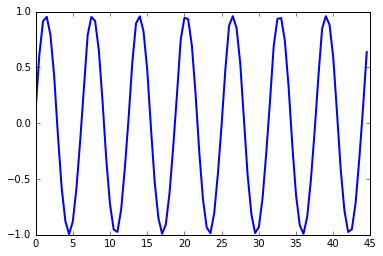

In [6]:
Y_predicted = model.predict(X, batch_size=100)
line, = plt.plot(lins[0:180:shift],Y_predicted[0:int(180/shift),:], '-', linewidth=2)